<a href="https://colab.research.google.com/github/yejikwon7/AI/blob/main/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요한 라이브러리 불러오기

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

# torchvision.datasets에 MNIST 등의 다양한 데이터를 사용하기 위해 용이하게 정리
import torchvision.datasets as dset   # data set 불러오기 위함

# torchvision.transforms에는 이미지 데이터를 자르거나 확대 및 다양하게 변형시키는 함수 구현
import torchvision.transforms as transforms   # 변형 작업 수행 위함

# DataLoader는 전처리가 끝난 데이터들을 지정한 배치 크기에 맞게 모아서 전달해주는 역할
from torch.utils.data import DataLoader
import numpy as np # array
import matplotlib.pyplot as plt # 그래프

print(torch.__version__)

2.5.1+cu121


하이퍼 파라미터 지정

In [8]:
batch_size = 256
learning_rage = 0.0002
num_epoch = 10

데이터 다운로드

In [9]:
# 첫 번째 인자 root는 데이터 저장할 위치, train은 학습용 데이터인지 테스트용 데이터인지의 여부를 의미

# MNIST 데이터는 숫자 손글씨 이미지와 이에 대한 정답 쌍으로 이루어짐
# transform은 이미지에 대한 변형, target_transform은 정답 라벨에 대한 변형을 의미
# transform.ToTensor()는 PIL 이미지나 Numpy 배열을 토치 텐서로 바꿈

# download는 데이터가 저장할 위치에 없을 경우 새로 다운받을지 여부
mnist_train = dset.MNIST("../", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
# ToTensor: conv 연산 수행하기 위함
# target_transform: label에 대한 변형
mnist_test = dset.MNIST("../", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

데이터셋 체크

In [10]:
print(mnist_train.__getitem__(0)[0].size(), mnist_train.__len__())
print(mnist_test.__getitem__(0)[0].size(), mnist_test.__len__())

print(len(mnist_train), len(mnist_test))

torch.Size([1, 28, 28]) 60000
torch.Size([1, 28, 28]) 10000
60000 10000


DataLoader 설정: 미니 배치 단위로 구성해야 함

In [11]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
# batch_size=batch_size: 배치 단위로 나눔
# shuffle: 순차적으로 구성된 data인 경우
# drop_last: 남은 data 사용할지 -> 사용X, 온전히 256개로 지정된 data만 사용
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

CNN 모델

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # conv layer 한꺼번에 묶음
        self.layer = nn.Sequential( # 순차적 수행
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5), # stride=1, padding=0
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    # 먼저 수행
    def forward(self, x): # 데이터 받아옴
        out = self.layer(x) # init에 선언
        out = out.view(batch_size, -1) # 평탄화

        out = self.fc_layer(out)
        return out

손실 함수, 최적화 함수

In [13]:
# gpu가 사용 가능한 경우에는 device를 gpu로 설정하고 불가능하면 cpu로 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 모델을 지정한 장치로 올림
model = CNN().to(device)
# class로 선언한 모델 가져옴
# 데이터도 동일하게 올려야 함

# 손실함수는 크로스엔트로피 사용
loss_func = nn.CrossEntropyLoss()

# 최적화 함수는 Adam을 사용
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rage)

cuda:0


학습

In [14]:
loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader): # iteration
    # j: 배치 몇 번째인지
        x = image.to(device)
        y_ = label.to(device)

        optimizer.zero_grad()
        output = model.forward(x) # 순전파
        loss = loss_func(output, y_) # 손실값
        loss.backward() # backpropagation, 기울기 구함
        optimizer.step() # 최적화

        if j % 1000 == 0: # 1000 iteration마다
            print(loss)
            loss_arr.append(loss.cpu().detach().numpy())

tensor(2.3138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0821, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0612, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0402, device='cuda:0', grad_fn=<NllLossBackward0>)


학습 시 손실 시각화

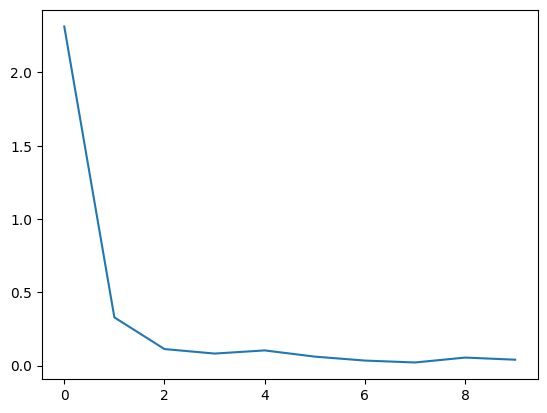

In [15]:
plt.plot(loss_arr)
plt.show()

테스트 데이터 정확도 측정

In [16]:
# 맞은 개수, 전체 개수를 저장할 변수를 지정
correct = 0
total = 0

# 인퍼런스 모드를 위해 no_grad 함
with torch.no_grad():
    # 테스트로더에서 이미지와 정답 불러옴
    for image, label in test_loader:
        # 두 데이터 모두 장치에 올림
        x = image.to(device)
        y_ = label.to(device)

        # 모델에 데이터 넣고 결과값 얻음
        output = model.forward(x)

        # 최댓값은 필요없으므로 인덱스만 사용
        _, output_index = torch.max(output, 1)

        # 전체 개수는 라벨의 개수로 더함
        # 전체 개수를 알고 있음에도 batch_size, drop_last 영향으로 데이터 잘릴 수 있으므로 수행
        total += label.size(0)

        # 모델 결과의 최댓값 인덱스와 라벨이 일치하는 개수를 correct에 더함
        correct += (output_index == y_).sum().float()

    # 테스트 데이터 전체에 대해 위의 작업을 시행 후 정확도 구함
    print("Accuracy of Test Data: {}".format(100*correct/total))

Accuracy of Test Data: 98.87820434570312
